In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
water_data.isnull().mean() * 100

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [4]:
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [5]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

**Hold-out метод**

Основные параметры train_test_split():

*arrays — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.

test_size — размер тестовой (валидационной) выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-train_size.

train_size — размер тренировочной выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-test_size.

random_state — число, на основе которого производится генерация случайных чисел.

shuffle — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию True).

stratify — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

In [6]:
from sklearn.model_selection import train_test_split

#Двухкомпонентный подхо
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X, y, test_size=0.2, random_state=42)

display(f'Train shape: {X_train_2.shape}')
display(f'Valid shape: {X_valid_2.shape}')

#Трехкомпонентный подход
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

display(f'Train shape: {X_train.shape}')
display(f'Valid shape: {X_valid.shape}')
display(f'Test shape: {X_test.shape}')

'Train shape: (2620, 9)'

'Valid shape: (656, 9)'

'Train shape: (2620, 9)'

'Valid shape: (328, 9)'

'Test shape: (328, 9)'

Построение дерева решений

In [12]:
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7,
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42
)

model.fit(X_train_2, y_train_2)

y_train_pred = model.predict(X_train_2)
y_valid_pred = model.predict(X_valid_2)

print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train_2, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid_2, y_valid_pred)))


Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


K-Fold метод (кросс-валидация)

In [14]:
#Создаем модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

#Создаем объект кросс-валидатора KFold
kf = model_selection.KFold(
    n_splits=5, #число фолдов
    shuffle=False #перемешивать ли исходный набор данных
)

train_metrics = []
val_metrics = []

# Организуем цикл для кросс-валидации (используем весь набор данных)
# train_index - индексы тренировочной выборки
# valid_index - индексы валидационной выборки
for train_index, valid_index in kf.split(X, y):
    # Создаем тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    # Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    # Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    # Рассчитываем метрику и заносим ее в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))


display(train_metrics)
display(val_metrics)  


[0.8034351145038168,
 0.8168637924456315,
 0.8027470431133156,
 0.8267836703548264,
 0.8157191911484166]

[0.7957317073170732,
 0.7053435114503817,
 0.7358778625954199,
 0.7282442748091603,
 0.732824427480916]

In [15]:
# Усредненные значения метрик
display('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
display('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

'Train k-fold mean accuracy: 0.81'

'Valid k-fold mean accuracy: 0.74'

На самом весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — cross_validate() из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.

Основные параметры функции cross_validate():

estimator — модель, качество которой будет проверяться на кросс-валидации.

X — матрица наблюдений.

y — вектор-столбец правильных ответов.

cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.

scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).

return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

fit_time — время обучения модели на каждой итерации кросс-валидации;


score_time — время вычисления метрик на каждой итерации кросс-валидации;

test_score — значения метрик на валидационных фолдах;

train_score — значения метрик на тренировочных фолдах.

In [16]:
#Создаем модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

#Создаем объект кросс-валидатора KFold
kf = model_selection.KFold(
    n_splits=5, #число фолдов
    shuffle=False #перемешивать ли исходный набор данных
)

#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X, # матрица наблюдений Х
    y=y, # вектор ответов у
    cv=kf, # кросс-валидатор
    scoring='accuracy', # метрика
    return_train_score=True # подсчет метрики на тренировочных фолдах
)

display(cv_metrics)

{'fit_time': array([0.03690171, 0.03590298, 0.03291059, 0.02991629, 0.02892065]),
 'score_time': array([0.0019958 , 0.0019958 , 0.00100017, 0.00099921, 0.00199628]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [17]:
display('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
display('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

'Train k-fold mean accuracy: 0.81'

'Valid k-fold mean accuracy: 0.74'

LEAVE-ONE-OUT метод отложенного примера или поэлементная кросс валидация

In [18]:
#Создаем модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

#Создаем кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()

#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model,
    X=X.iloc[:500],
    y=y.iloc[:500],
    cv=loo,
    scoring='accuracy',
    return_train_score=True
)



In [19]:
display('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
display('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

'Train k-fold mean accuracy: 0.95'

'Valid k-fold mean accuracy: 0.90'

**Дисбаланс выборки**

In [21]:
# стратифицированное разбиение
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


In [22]:
# Стратифицированное разбиение по методу k-fold
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

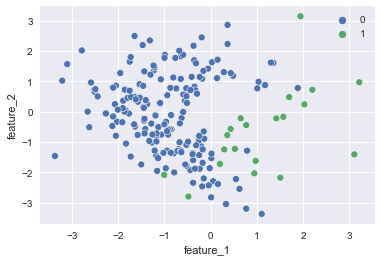

In [24]:
#генерация случайного датасета
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #кол-во объектов
    n_features=2, # кол-во признаков
    n_informative=2, #кол-во информативных признаков
    n_redundant=0, #кол-во неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=42
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y)

In [25]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [28]:
# Задание 3.5
from sklearn import linear_model

log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_valid_pred = log_reg.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.50      0.50      0.50         4

    accuracy                           0.90        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.90      0.90      0.90        40



In [29]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


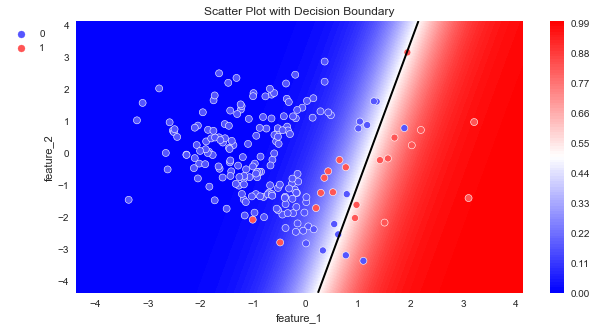

In [30]:
plot_probabilities_2d(X, y, log_reg)

In [33]:
# Балансировка весов классов (при дисбалансе)
log_reg_2 = linear_model.LogisticRegression(class_weight='balanced')
log_reg_2.fit(X_train, y_train)

y_train_pred = log_reg_2.predict(X_train)
y_valid_pred = log_reg_2.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        36
           1       0.50      1.00      0.67         4

    accuracy                           0.90        40
   macro avg       0.75      0.94      0.80        40
weighted avg       0.95      0.90      0.91        40



c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


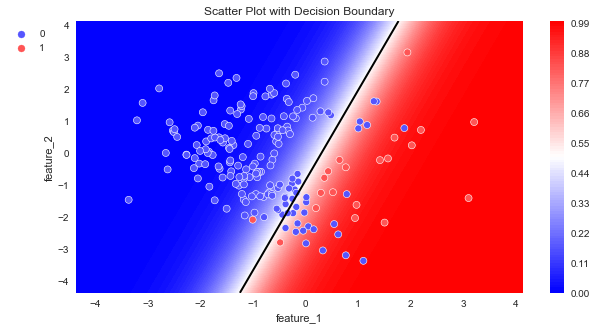

In [34]:
plot_probabilities_2d(X, y, log_reg_2)

Построение PR-кривой и сравнение моделей по данному критерию

In [35]:
# Создаем модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)
# Обучаем модель
model.fit(X_train, y_train)
# Создаем кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [38]:
# Выделяем столбец с вероятностями для класса 1
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [39]:
# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Threshold:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:', recall[:5])

Threshold: [0.         0.14285714 0.2        0.22222222 0.28571429]
Precision scores: [0.1        0.5        0.52       0.6        0.66666667]
Recall scores: [1.     0.875  0.8125 0.75   0.75  ]


Best threshold = 0.56, F1-Score = 0.75


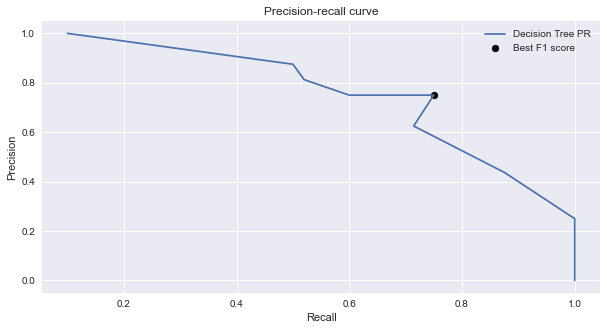

In [40]:
# Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
# Определяем индекс максимум (функция argmax())
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5))
# Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
# Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx],  marker='o', color='black', label='Best F1 score')
# Даем графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

In [44]:
# Образцы воды, для которых вероятность быть пригодным для питья > threshold_opt, относим к классу 1
# В противном случае к классу - 0
threshold_opt = 0.56

y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
# Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        36
           1       0.60      0.75      0.67         4

    accuracy                           0.93        40
   macro avg       0.79      0.85      0.81        40
weighted avg       0.93      0.93      0.93        40



In [45]:
# Вычисление метрики PR AUC - площадь под кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.77


Сэмплирование

In [46]:
from imblearn.over_sampling import SMOTE

In [49]:
sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

In [50]:
print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (160, 2)
Class balance before oversampling: 
0    144
1     16
dtype: int64
----------------------------------------
Train shape after oversampling: (288, 2)
Class balance after oversampling: 
0    144
1    144
dtype: int64


In [51]:
log_reg_3 = linear_model.LogisticRegression()
log_reg_3.fit(X_train_s, y_train_s)

y_valid_pred_s = log_reg_3.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred_s))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        36
           1       0.50      1.00      0.67         4

    accuracy                           0.90        40
   macro avg       0.75      0.94      0.80        40
weighted avg       0.95      0.90      0.91        40



c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


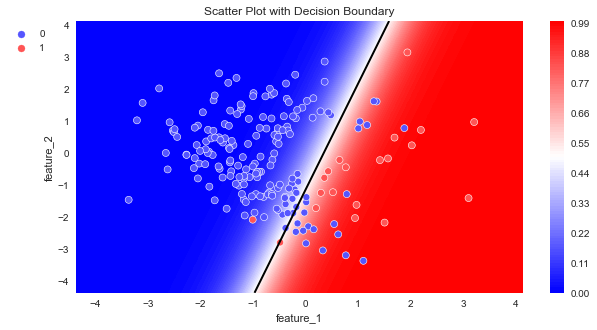

In [52]:
plot_probabilities_2d(X, y, log_reg_3)

Проблемы недообучения и переобучения

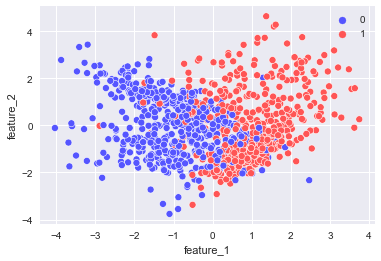

In [53]:
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [57]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

model_1 = tree.DecisionTreeClassifier(max_depth=10)
model_1.fit(X_train, y_train)

y_train_pred_1 = model_1.predict(X_train)
y_valid_pred_1 = model_1.predict(X_valid)

print('Train accuracy score: {}'.format(metrics.accuracy_score(y_train, y_train_pred_1)))
print('Valid accuracy score: {}'.format(metrics.accuracy_score(y_valid, y_valid_pred_1)))

Train accuracy score: 0.9814285714285714
Valid accuracy score: 0.82


c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


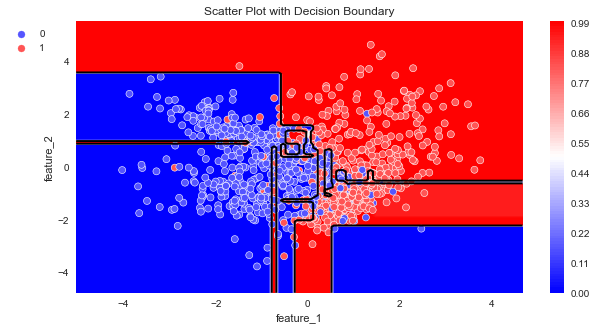

In [58]:
plot_probabilities_2d(X, y, model_1)

In [59]:
model_2 = tree.DecisionTreeClassifier(max_depth=3)
model_2.fit(X_train, y_train)

y_train_pred_2 = model_2.predict(X_train)
y_valid_pred_2 = model_2.predict(X_valid)

print('Train accuracy score: {}'.format(metrics.accuracy_score(y_train, y_train_pred_2)))
print('Valid accuracy score: {}'.format(metrics.accuracy_score(y_valid, y_valid_pred_2)))

Train accuracy score: 0.88
Valid accuracy score: 0.85


c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


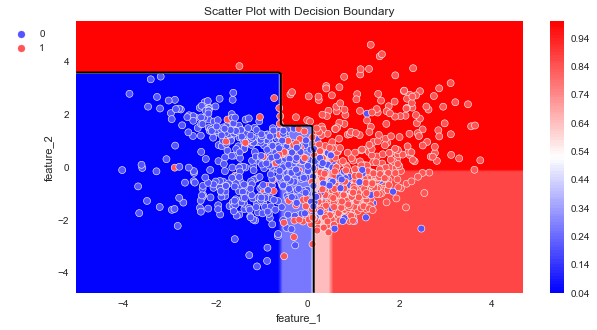

In [60]:
plot_probabilities_2d(X, y, model_2)